### part 5 : application of unsupervised learning

Pick a dataset and perform an unsupervised learning on it. Your dataset has to be different from any dataset seen during the course.

Important: please try to justify your processing. Why is it interesting to do a clustering / dimensionality reduction / density estimation on this dataset ? What problem are we trying to solve ?

Suggestion of steps :

— present the dataset shortly in your own words (please do not copy a description from another resource) and link to the url where you downloaded it from.

— provide general analysis of the dataset, that studies its statistical properties, outliers, correlation matrices, or any other interesting analysis.

— if relevant or necessary, preprocess the data, and to justify this preprocessing. You could compare the results obtained with and without preprocessing.

— discuss the relevant optimization details

— (mandatory) provide an evaluation or multiple evaluations of the results, thanks to scorings of your choice.

— for a clustering, it can be an inertia, a normalized cut...

— for a dimensionality reduction, the explained variance

— for a density estimation, the kullbach leibler divergence between the da-
taset and a dataset sampled from the estimated distribution

— but you are encouraged to use other evaluations if they are more relevant for your processing.

— Feel free to add useful visualizations for each step of your processing.

— discuss the results obtained. Have we solved a problem with this processing ?


Some resources to find datasets (but you probably know other good resources already) : Link 1, Link 2, Link 4. If necessary, you can tweak a dataset in order to artificially make it possible to apply techniques that you like, or downsample it.

This is not a production project and you are encouraged to experiment.

## Dataset presentation

First of all, we will present the dataset we choose. We choose the dataset "Breast Cancer Wisconsin (Diagnostic) Data Set" (https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data/) from Kaggle. This dataset is composed of 569 instances and 32 features.

The goal is to predict if a tumor is benign or malignant.

#### Features description

**Identification features:**
- id: ID number **(suppressed for anonymization)**
- diagnosis: The diagnosis of breast tissues (M = malignant, B = benign) **(suppressed for evaluation, and replace by 1 for malignant and 0 for benign)**

**Usable features:**

Ten real-valued features are computed for each cell nucleus:
- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features


### 1: Reading the dataset and removing informative features

In [68]:
import pandas as pd

df = pd.read_csv("data.csv")

# Save labels in a new variable
LABELS = df['diagnosis'].map({'M':1,'B':0})

# Drop useless columns
df.drop('id',axis=1,inplace=True)
df.drop('Unnamed: 32',axis=1,inplace=True)
df.drop('diagnosis',axis=1,inplace=True)

df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### 2: Data analysis

First of all, we will study all the feature in order to find which one is the most useful for the classification.

In order to do so:
1. We will plot an histogram for each feature in order to see the distribution of the data.
2. We will extract the most important features.

#### 2.1 Histograms

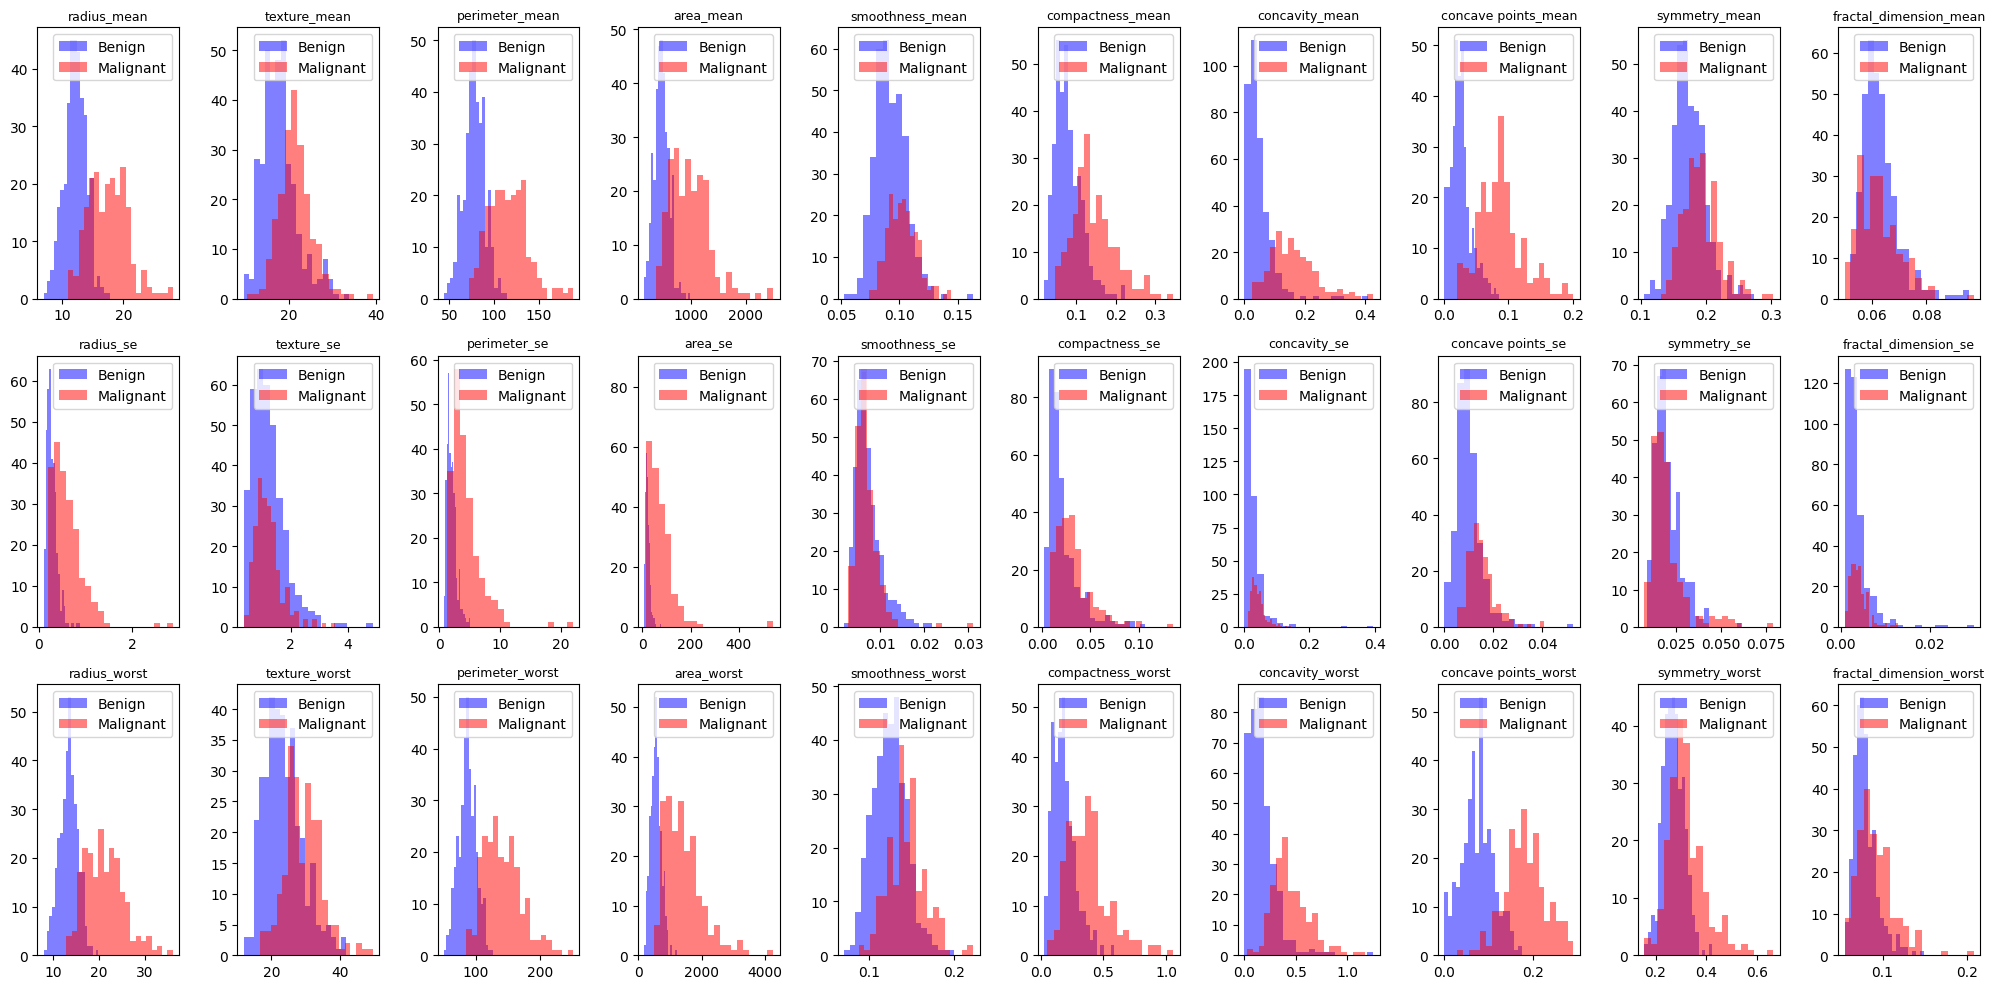

In [69]:
import matplotlib.pyplot as plt

# Subpot 3 rows of 10 columns

fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 10))

# For each feature, plot the histogram of benign and malignant values

for i, ax in enumerate(axes.flat):
    ax.hist(df[df.columns[i]][LABELS==0], bins=20, alpha=0.5, label='Benign', color='blue')
    ax.hist(df[df.columns[i]][LABELS==1], bins=20, alpha=0.5, label='Malignant', color='red')
    ax.set_title(df.columns[i], fontsize=9)
    ax.legend()

plt.tight_layout()
plt.show()

We can see visually that some features are more useful than others. We can see that the symmetry and the fractal dimension are not really useful for the classification. We can also see that the mean and the worst of the features can be useful for the classification, while the standard error is not really useful.


#### 2.2 Feature importance

But to establish a ranking of the features, we will need to use a more robust method. We will use the ExtraTreesClassifier from sklearn.ensemble to do so.

In [70]:
# Calcul the importance of each feature
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np

clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf.fit(df, LABELS)

importances = clf.feature_importances_
# Sort the features by importance
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(df.shape[1]):
    print("%d. %s (%f)" % (f + 1, df.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. concave points_worst (0.122537)
2. area_worst (0.095104)
3. radius_worst (0.089327)
4. perimeter_worst (0.082550)
5. area_mean (0.066395)
6. concave points_mean (0.065583)
7. concavity_mean (0.059336)
8. perimeter_mean (0.057979)
9. radius_mean (0.055119)
10. concavity_worst (0.036101)
11. compactness_worst (0.027780)
12. texture_mean (0.026716)
13. perimeter_se (0.023613)
14. texture_worst (0.023510)
15. area_se (0.020494)
16. radius_se (0.019699)
17. smoothness_worst (0.017825)
18. compactness_mean (0.012566)
19. symmetry_worst (0.012131)
20. smoothness_mean (0.010799)
21. fractal_dimension_worst (0.010550)
22. concavity_se (0.009950)
23. concave points_se (0.009263)
24. symmetry_mean (0.007862)
25. compactness_se (0.006612)
26. fractal_dimension_mean (0.006493)
27. symmetry_se (0.006477)
28. fractal_dimension_se (0.006166)
29. smoothness_se (0.005802)
30. texture_se (0.005659)


In this situation, we can saw that the concave points worst, the area worst and the radius worst are the most important features for the classification of the tumor.

### 3: Preprocessing

As we saw in the previous part, some features are useless for the classification. In order to optimize the classification, we will remove the 15 less important features, and we will keep the 15 most important features.

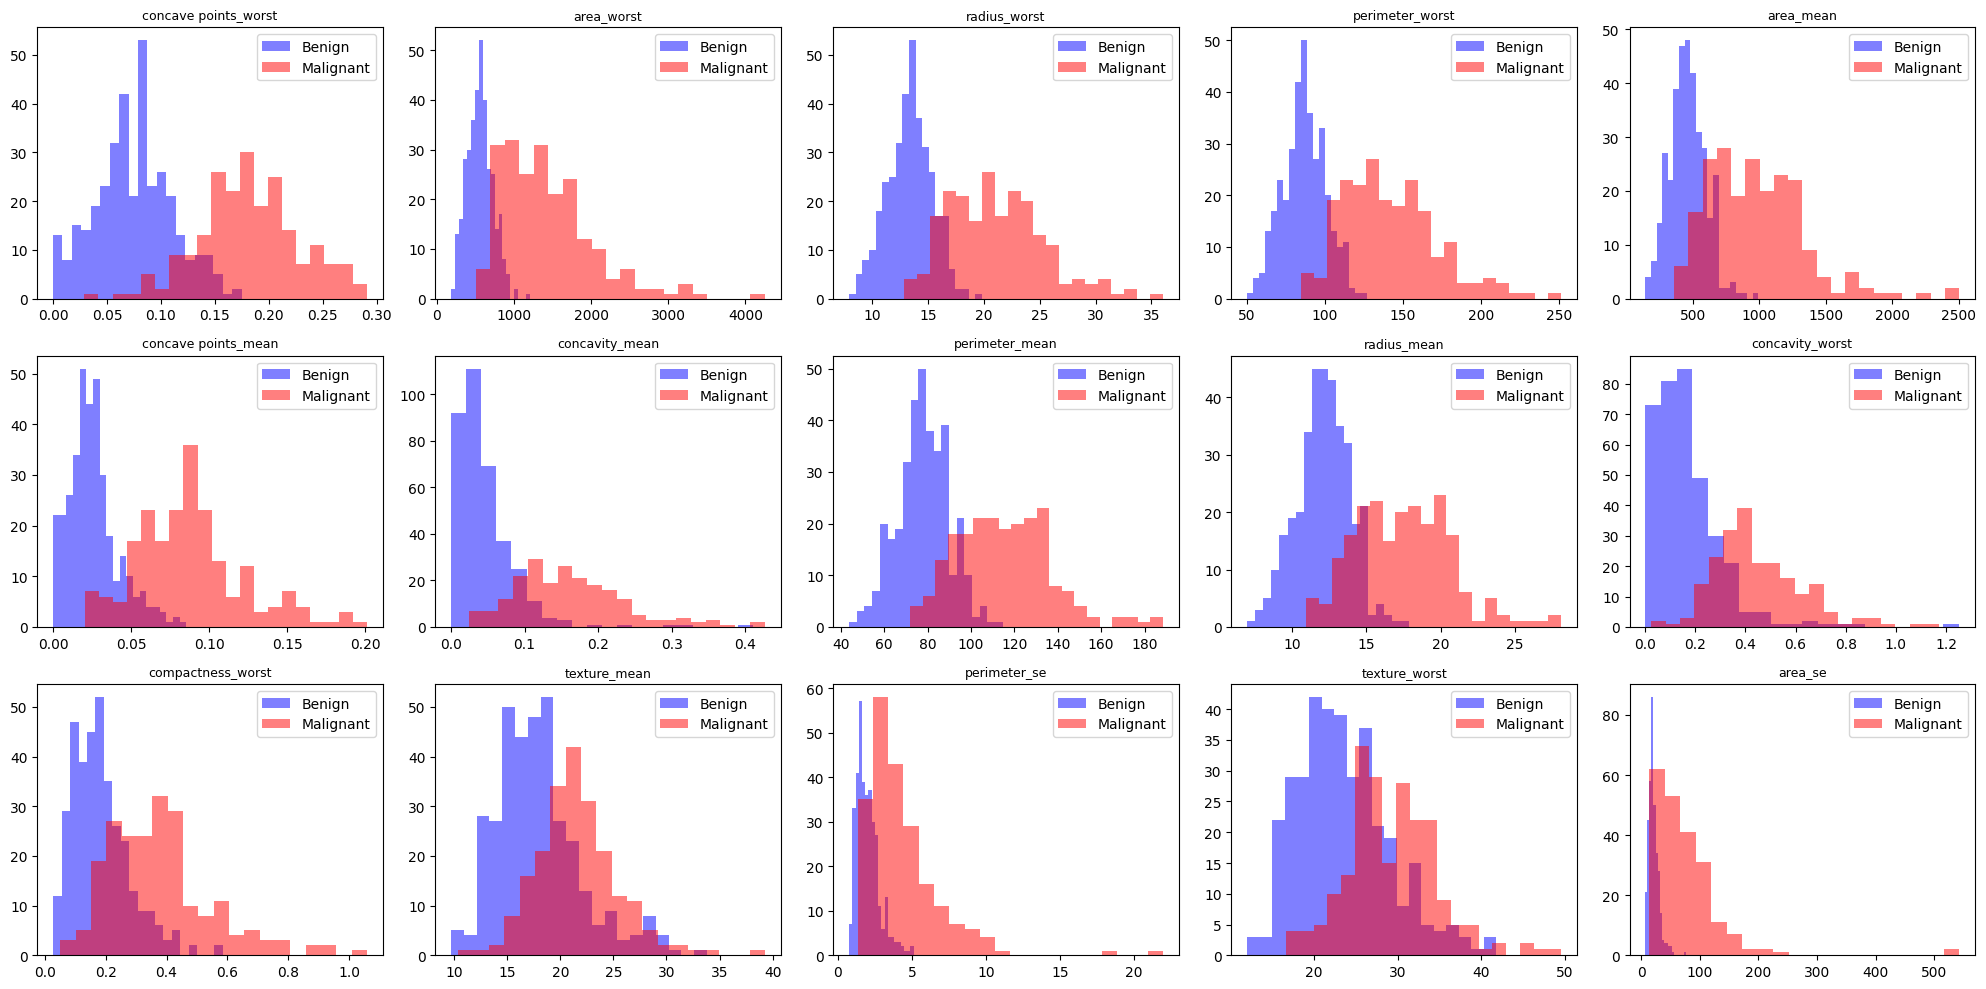

In [71]:
# Select the 15 most important features

df_important = df[df.columns[indices[:15]]]

# Plot the 10 most important features
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))

for i, ax in enumerate(axes.flat):
    ax.hist(df_important[df_important.columns[i]][LABELS==0], bins=20, alpha=0.5, label='Benign', color='blue')
    ax.hist(df_important[df_important.columns[i]][LABELS==1], bins=20, alpha=0.5, label='Malignant', color='red')
    ax.set_title(df_important.columns[i], fontsize=9)
    ax.legend()

plt.tight_layout()
plt.show()

Now that we have the 15 most important features, we will do a PCA in order to reduce the dimension of the dataset. We will reduce the dimension to 2, in order to be able to plot the data, and because only 2 dimensions does not impact the classification.

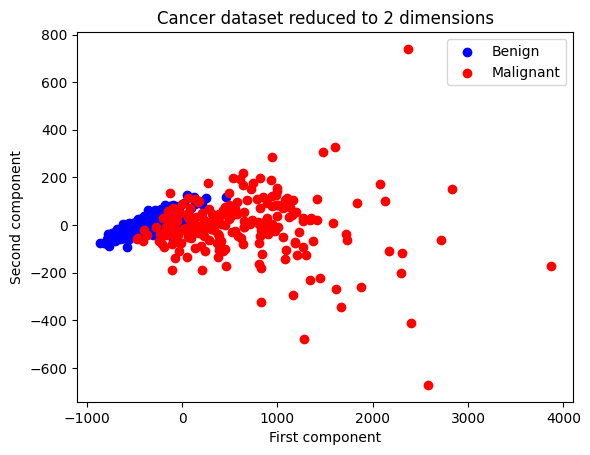

In [72]:
# Use the PCA to reduce the dimensionality of the dataset 
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_important)

# Plot the result
plt.scatter(df_pca[LABELS==0,0], df_pca[LABELS==0,1], color='blue', label='Benign')
plt.scatter(df_pca[LABELS==1,0], df_pca[LABELS==1,1], color='red', label='Malignant')
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title('Cancer dataset reduced to 2 dimensions')
plt.legend()
plt.show()


We can see that the data is well distributed, and that it can be globally separated in 2 clusters.

### 4: Classification

Now that we have a dataset with 2 dimensions, we will try to classify the data. We will use the KMeans algorithm from sklearn.cluster.

Accuracy score:  0.8541300527240774


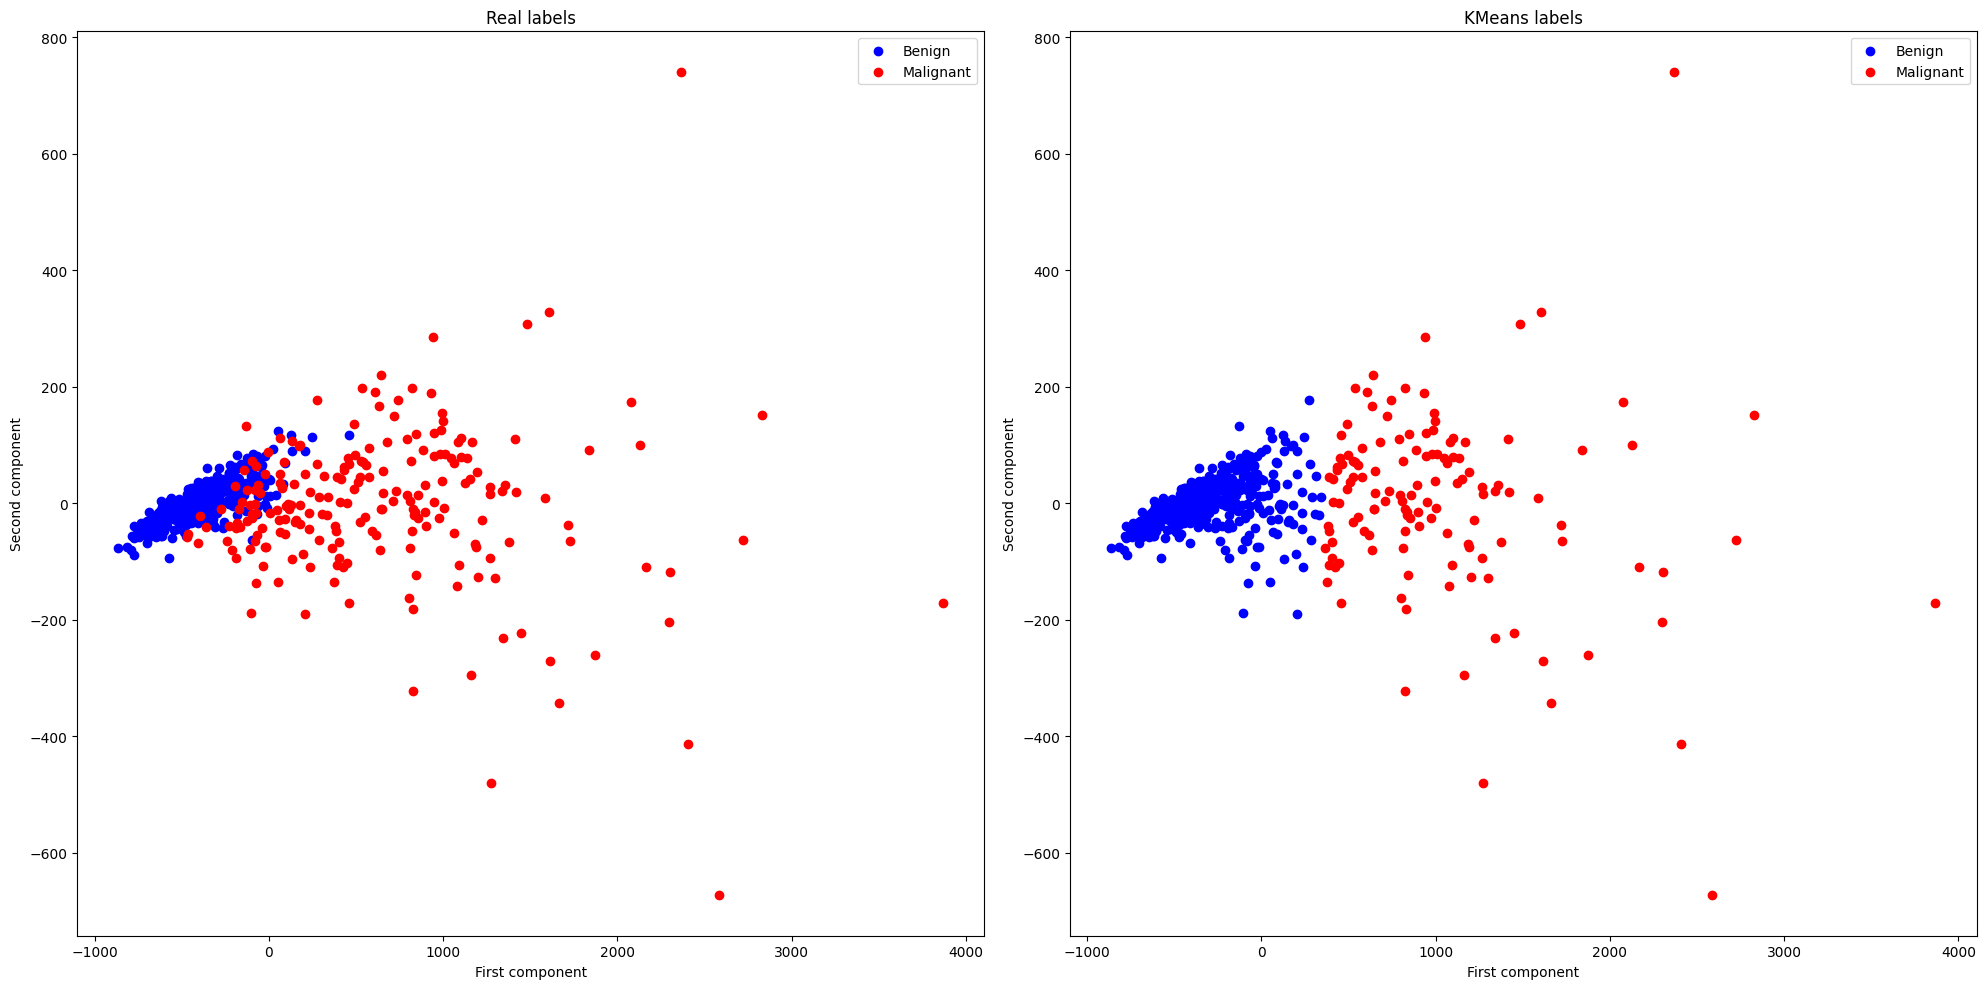

In [73]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Create a KMeans model with 2 clusters

Finded_labels_KMEANS = KMeans(n_clusters=2, n_init="auto").fit_predict(df_pca)

print("Accuracy score: ", accuracy_score(LABELS, Finded_labels_KMEANS))

# Plot the result

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

axes[0].scatter(df_pca[LABELS==0,0], df_pca[LABELS==0,1], color='blue', label='Benign')
axes[0].scatter(df_pca[LABELS==1,0], df_pca[LABELS==1,1], color='red', label='Malignant')
axes[0].set_xlabel('First component')
axes[0].set_ylabel('Second component')
axes[0].set_title('Real labels')
axes[0].legend()

axes[1].scatter(df_pca[Finded_labels_KMEANS==0,0], df_pca[Finded_labels_KMEANS==0,1], color='blue', label='Benign')
axes[1].scatter(df_pca[Finded_labels_KMEANS==1,0], df_pca[Finded_labels_KMEANS==1,1], color='red', label='Malignant')
axes[1].set_xlabel('First component')
axes[1].set_ylabel('Second component')
axes[1].set_title('KMeans labels')
axes[1].legend()

plt.tight_layout()
plt.show()

As we can see, the KMeans algorithm is able to classify the data with a good accuracy (85% of accuracy). But we can see that the algorithm has some difficultie to classify the data in the middle of the plot.

In order to establish if the unsupervised learning is better than the supervised learning, we will try to classify the data with a supervised learning algorithm, the KNeighborsClassifier from sklearn.neighbors.

Accuracy score:  0.9472759226713533


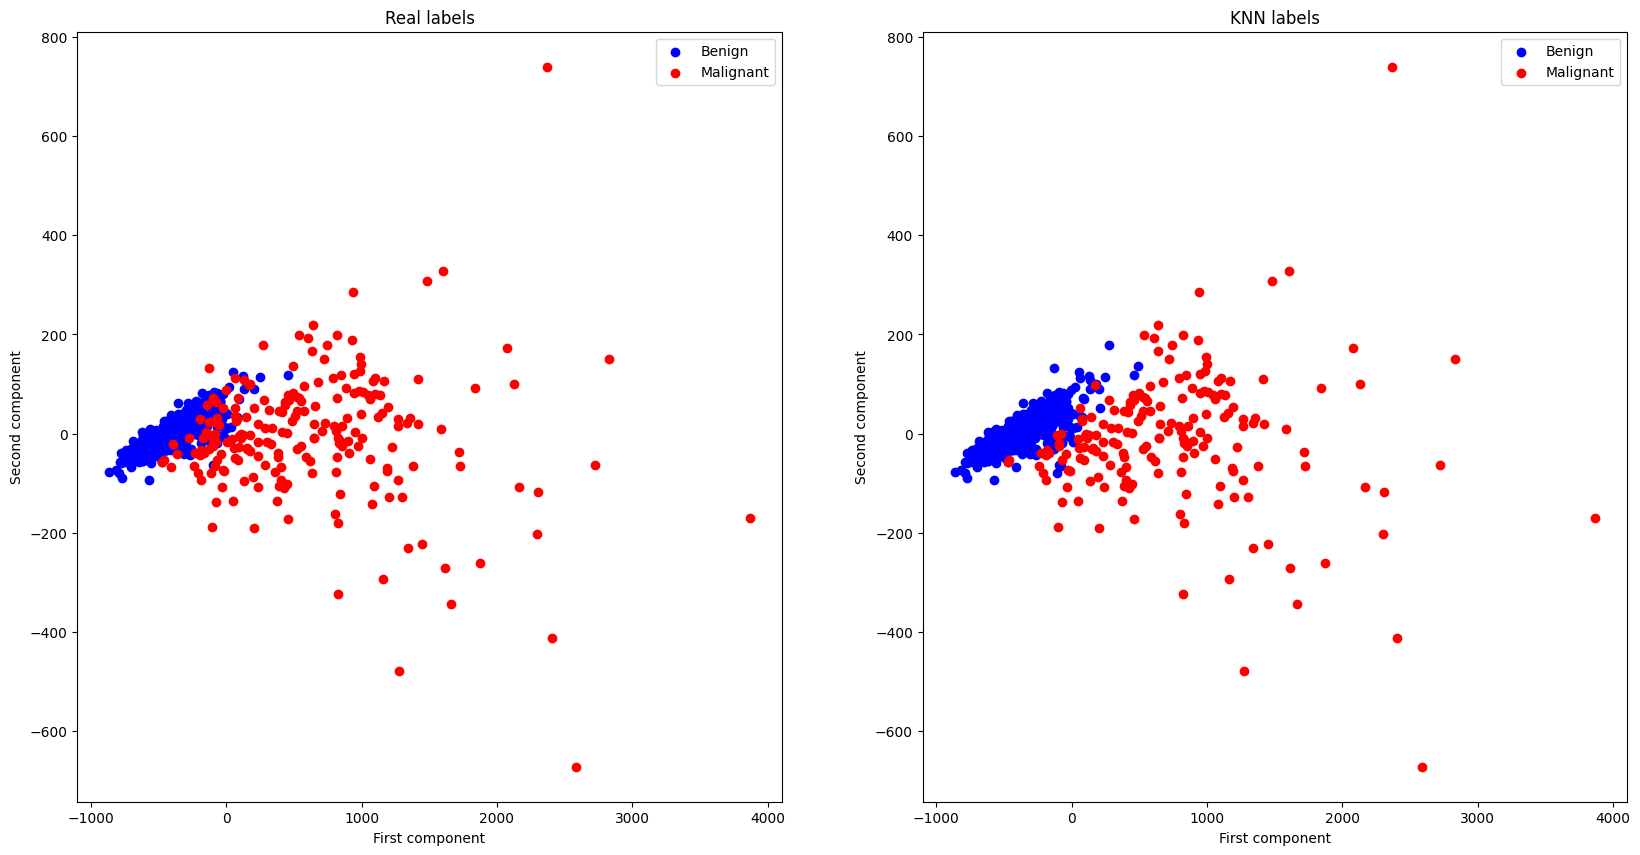

In [74]:
# Create a KNN model with 2 clusters
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(df_pca, LABELS)
Finded_labels_KNN = knn.predict(df_pca)
print("Accuracy score: ", accuracy_score(LABELS, Finded_labels_KNN))

# Plot the result
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

axes[0].scatter(df_pca[LABELS==0,0], df_pca[LABELS==0,1], color='blue', label='Benign')
axes[0].scatter(df_pca[LABELS==1,0], df_pca[LABELS==1,1], color='red', label='Malignant')
axes[0].set_xlabel('First component')
axes[0].set_ylabel('Second component')
axes[0].set_title('Real labels')
axes[0].legend()

axes[1].scatter(df_pca[Finded_labels_KNN==0,0], df_pca[Finded_labels_KNN==0,1], color='blue', label='Benign')
axes[1].scatter(df_pca[Finded_labels_KNN==1,0], df_pca[Finded_labels_KNN==1,1], color='red', label='Malignant')
axes[1].set_xlabel('First component')
axes[1].set_ylabel('Second component')
axes[1].set_title('KNN labels')
axes[1].legend()

plt.show()

We can see that the supervised learning algorithm is able to classify the data with a better accuracy (95% of accuracy) on his training set. It has less difficulties to classify the data in the middle of the plot.

In order to have a more precise evaluation of the classification, we will plot the confusion matrix of the classification.

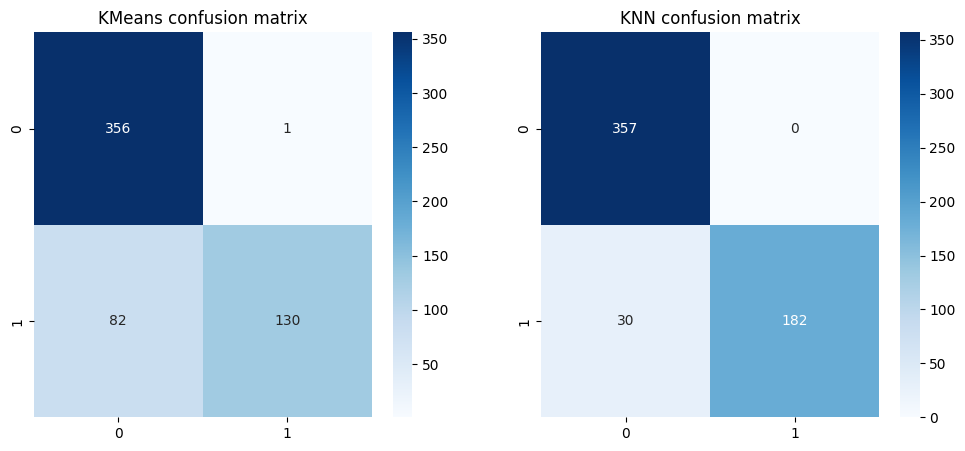

In [76]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,5), ncols=2)

cm = confusion_matrix(LABELS, Finded_labels_KMEANS)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title('KMeans confusion matrix')

cm = confusion_matrix(LABELS, Finded_labels_KNN)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title('KNN confusion matrix')

plt.show()

### 5: Conclusion

We can see that the unsupervised learning algorithm is less efficient than the supervised learning algorithm. But the Kmeans is able to classify the data with a good accuracy, and that it is able to classify if a tumor is benign or malignant.

Therefore, we can conclude that unsupervised learning algorithm is a good way to classify those data, but that the supervised learning is more efficient.

But as we used labels to select the more interesting features, we can consider that we used semi-supervised process. However, as the reduction of the number of features does not impact the classification accuracy (it only reduce the computational time), we can remove this part of the process, to be a fully unsupervised process.